### Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import logging
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc


### Setting up Logging

In [6]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


### Loading the Dataset
Description of the dataset and the objective of the analysis.

In [7]:
file_path = 'credit_risk_dataset.csv'  # Adjust as necessary
data = pd.read_csv(file_path)


### Identifying Categorical and Numerical Columns

In [8]:
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.drop('loan_status')


### Data Preprocessing

In [9]:
X = data.drop('loan_status', axis=1)  # Drop the target variable
y = data['loan_status']               # Target variable


### Splitting the Dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Defining the Preprocessing for Numerical and Categorical Features

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with the median
            ('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with the most frequent
            ('encoder', OneHotEncoder())]), categorical_cols)
    ])


### Creating and Training the Pipeline

In [12]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))])

pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Model Evaluation with Cross-Validation

In [13]:
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
logger.info(f'Average 5-Fold ROC AUC: {cv_scores.mean()}')


INFO:__main__:Average 5-Fold ROC AUC: 0.9273912789288048


### Making Predictions and Evaluating the Model

In [14]:
predictions = pipeline.predict(X_test)
prediction_probs = pipeline.predict_proba(X_test)[:, 1]

logger.info("\n" + classification_report(y_test, predictions))
logger.info(f'ROC AUC Score: {roc_auc_score(y_test, prediction_probs)}')


INFO:__main__:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7613
           1       0.97      0.72      0.83      2162

    accuracy                           0.93      9775
   macro avg       0.95      0.86      0.89      9775
weighted avg       0.94      0.93      0.93      9775

INFO:__main__:ROC AUC Score: 0.9334778756771398


### Confusion Matrix Visualization

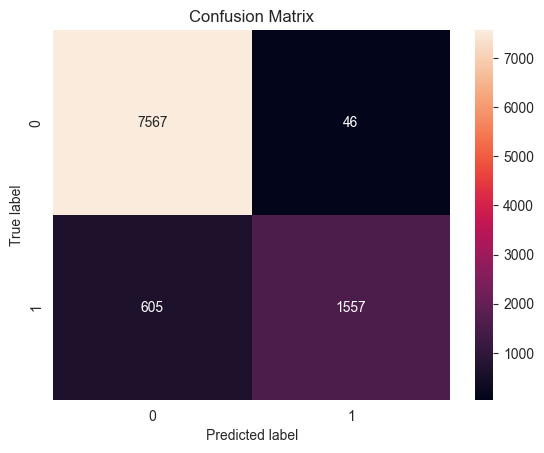

In [15]:
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### ROC Curve Visualization

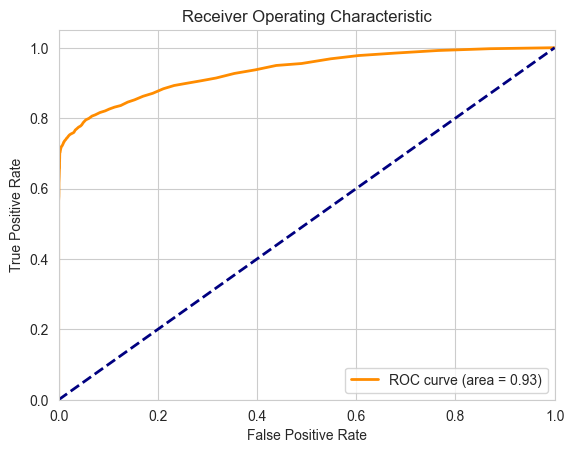

In [16]:
fpr, tpr, _ = roc_curve(y_test, prediction_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Feature Importance Visualization

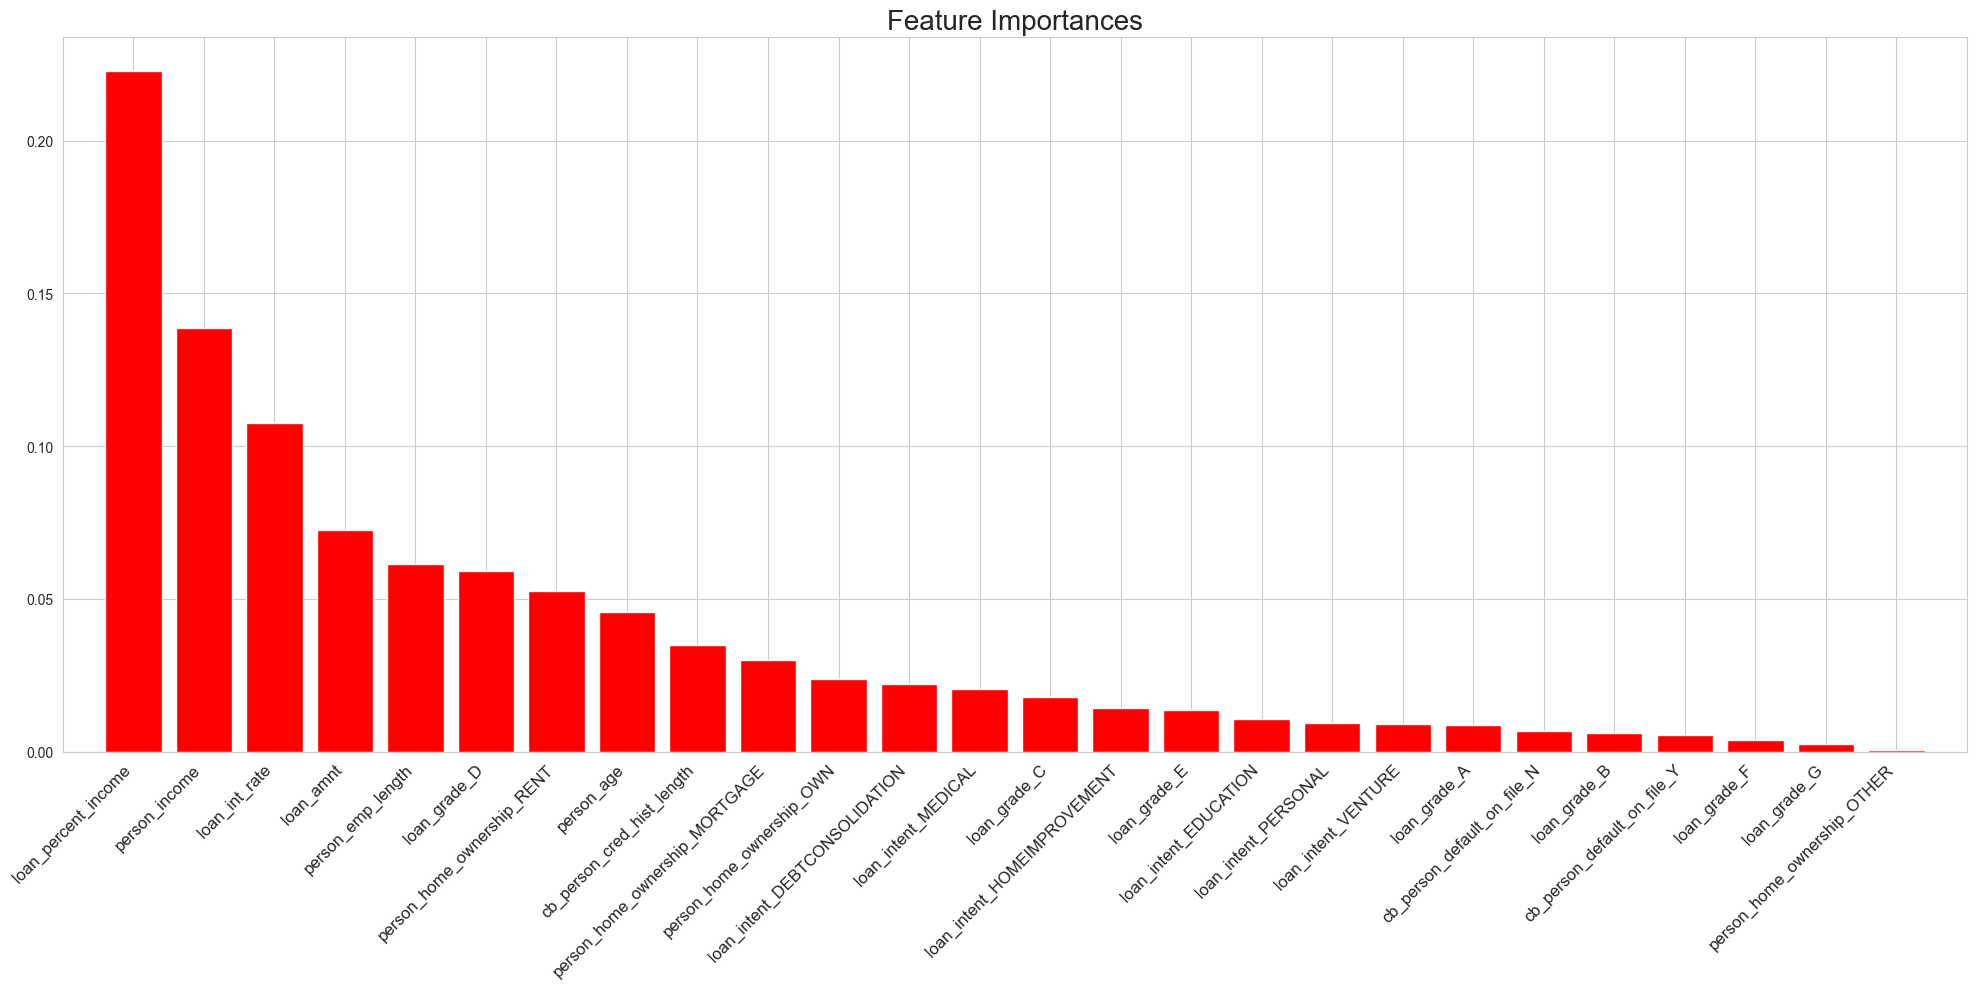

In [17]:
importances = pipeline.named_steps['classifier'].feature_importances_
feature_names_transformed = preprocessor.named_transformers_['num'].get_feature_names_out(numerical_cols).tolist() + \
                            preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20, 10))
plt.title('Feature Importances', fontsize=20)
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), [feature_names_transformed[i] for i in indices], rotation=45, ha="right", fontsize=12)
plt.xlim([-1, len(indices)])
plt.tight_layout()
plt.show()


### Saving the Model

In [18]:
joblib.dump(pipeline, 'credit_risk_model.pkl')


['credit_risk_model.pkl']